In [1]:
# Given alpha the threshold required for different sample size s
library("TailRank")

Loading required package: oompaBase


In [2]:
single_proba <- function(s, n, a=1, b=1, risk=0.1, h0_p=0.5, approximation=FALSE) {
    if (!approximation) {
        sa = qbinom(1 - risk, s, h0_p)
    } else {
        sa = qnorm(1 - risk, mean=s * h0_p, sd= sqrt(s * h0_p *  (1 - h0_p)))
    }
    # Return P(X > n/2 - sa | sa+a, sb+b) = 1 - P(X <= n/2 - sa | sa+a, sb+b)
    return(1 - pbb(n/2 - sa, n - s, sa+a, s-sa+b))
}

In [3]:
n = 100000
risk = 0.05
a = 1
b = 1
approximation = TRUE
ss = 1:5000
h0_p = 0.5
probas = c()
for (s in ss) {
    probas[s] <- single_proba(s, n, a=a, b=b, risk=risk, h0_p=h0_p, approximation=approximation)
}
plot(ss, probas, type="l")
print(probas)

   [1] 0.7499975 0.8750000 0.9375013 0.9687516 0.8906273 0.9375033 0.9648470
   [8] 0.9101612 0.9453178 0.9672900 0.9270092 0.9538644 0.9102265 0.9407745
  [15] 0.9616020 0.9282798 0.9518844 0.9164792 0.9423538 0.9608347 0.9331150
  [22] 0.9534442 0.9242227 0.9461404 0.9622553 0.9389798 0.9564378 0.9319983
  [29] 0.9506510 0.9252173 0.9449300 0.9599482 0.9392998 0.9552568 0.9337780
  [36] 0.9505890 0.9283762 0.9459629 0.9596795 0.9413924 0.9558125 0.9368878
  [43] 0.9519590 0.9324569 0.9481298 0.9605589 0.9443336 0.9573152 0.9405775
  [50] 0.9540772 0.9368668 0.9508517 0.9332058 0.9476450 0.9593226 0.9444618
  [57] 0.9565642 0.9413064 0.9538108 0.9381820 0.9510667 0.9350914 0.9483357
  [64] 0.9592016 0.9456208 0.9568265 0.9429249 0.9544545 0.9402501 0.9520886
  [71] 0.9375983 0.9497313 0.9597950 0.9473848 0.9577281 0.9450508 0.9556626
  [78] 0.9427312 0.9536006 0.9404272 0.9515438 0.9381403 0.9494939 0.9590296
  [85] 0.9474521 0.9572150 0.9454198 0.9554019 0.9433981 0.9535915 0.9413880

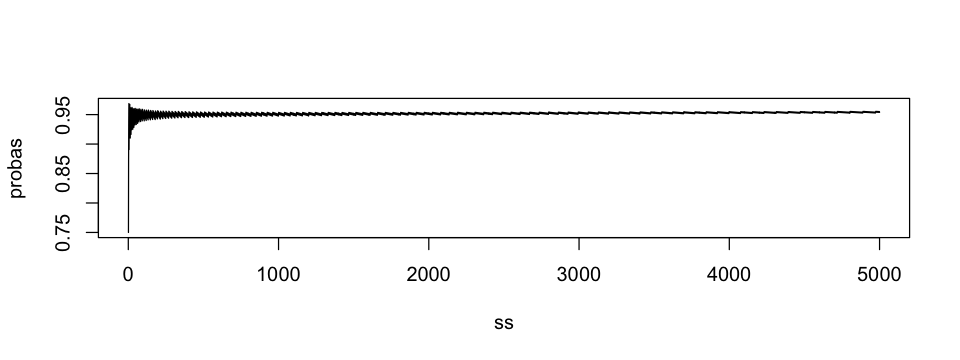

In [63]:
n = 100000
risk = 0.05
a = 1
b = 1
approximation = FALSE
ss = 1:5000
h0_p = 0.5
probas = c()
for (s in ss) {
    probas[s] <- single_proba(s, n, a=a, b=b, risk=risk, h0_p=h0_p, approximation=approximation)
}
plot(ss, probas, type="l")
print(probas)

In [94]:
check_rejection <- function(sample_winner, sample_loser, n, a, b, thresh=0.95, return_prob=FALSE) {
    p_win = 1 - pbb(n/2-sample_winner, n - sample_winner - sample_loser, sample_winner+a, sample_loser+b)
    if (return_prob) {
        return(p_win)
    }
    return(p_win >= thresh)
}

#' Try to simulate the random walk of a two candidate election auditing process.
#' Need to specify either
#'     - m: The number of votes till stopping
#'     - replacement: False -> to go for a full audit
#' The auditing will not stop until
#'     - The winner is declared winning
#'     - The audit reached threshold m (default to n)
#'     - Input didn't meet above condition
#' The simulation will return
#'     - The number of ballot drawn (1 to m)
rw_simulation <- function(n, m, step=1, a=1, b=1, thresh=0.95, risk=0.1, h1_p=0.6, 
                          h0_p=0.5, replacement=TRUE, show_walk=FALSE) {
    s = 0
    if (m == -1 && replacement) {
        return(0)
    } else if (m == -1) {
        m = n
    }
    vote_winner = n * h1_p
    vote_loser = n * (1-h1_p)
    
    sample_winner = 0
    sample_loser = 0
    walk = c()
    while (s < m) {
        # Advance the counter
        s = s + step
        # Sample a batch of votes
        batch = rbinom(1, step, vote_winner/(vote_loser+vote_winner))
        if (!replacement) {
            # If no replacement then remove those votes from poll
            vote_winner = vote_winner - batch
            vote_loser = vote_loser - (step - batch)
        }
        sample_winner = sample_winner + batch
        sample_loser = sample_loser + (step - batch)
        walk = c(walk, sample_winner, sample_loser)
        
        # If rejected null hypothesis (or accepted the alternative hypothesis)
        if (check_rejection(sample_winner, sample_loser, n, a, b, thresh)) {
            if (show_walk) {
                return(list(s=s, walk=matrix(walk, nrow=2)))
            }
            return(s)
        }
    }
    return(s)
}

In [100]:
total = 0
no_stop = 0
times = 100
stop = 3000
for (i in 1:times) {
    s = rw_simulation(100000, stop, h1_p=0.51, replacement=TRUE)
    total = total + s
    if (s >= stop) {
        no_stop = no_stop + 1
    }
}
c(total / times, no_stop)

[1] 1308.38   30.00